<a href="https://colab.research.google.com/github/elhamng/MLinChemistry/blob/master/AMD_S_C_ML_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning based method for predection of solubility
The machine learning method uses 2D or 3D features generated from molecular structures to fit a regression model for prediction. We use python with rdkit and sklearn to predict Solubility trained.

In [3]:
! pip install pandas==0.24.2

     |████████████████████████████████| 10.1 MB 2.3 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.2
    Uninstalling pandas-1.1.2:
      Successfully uninstalled pandas-1.1.2


In [1]:
# Install RDKit. Takes 2-3 minutes
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge python=3.7
!time conda install -q -y -c conda-forge rdkit

--2020-09-13 18:46:31--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-09-13 18:46:31--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93052469 (89M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  88.74M   225MB/s    in 0.4s    

2020-09-13 18:46:31 (225 MB/s) - ‘Miniconda3-latest-Linux

In [2]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Reading and Preprocessing

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
df = pd.read_csv('/content/drive/My Drive/solubility-dataset.csv')

In [7]:
df.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility
0,E-1,n-pentane,"InChI=1S/C5H12/c1-3-5-4-2/h3-5H2,1-2H3",OFBQJSOFQDEBGM-UHFFFAOYSA-N,CCCCC,-3.18
1,E-2,cyclopentane,InChI=1S/C5H10/c1-2-4-5-3-1/h1-5H2,RGSFGYAAUTVSQA-UHFFFAOYSA-N,C1CCCC1,-2.64
2,E-3,n-hexane,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",VLKZOEOYAKHREP-UHFFFAOYSA-N,CCCCCC,-3.84
3,E-4,2-methylpentane,"InChI=1S/C6H14/c1-4-5-6(2)3/h6H,4-5H2,1-3H3",AFABGHUZZDYHJO-UHFFFAOYSA-N,CCCC(C)C,-3.74
4,E-5,"2,2-dimethylbutane","InChI=1S/C6H14/c1-5-6(2,3)4/h5H2,1-4H3",HNRMPXKDFBEGFZ-UHFFFAOYSA-N,CCC(C)(C)C,-3.55


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1291 entries, 0 to 1290
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          1291 non-null   object 
 1   Name        1291 non-null   object 
 2   InChI       1291 non-null   object 
 3   InChIKey    1291 non-null   object 
 4   SMILES      1291 non-null   object 
 5   Solubility  1291 non-null   float64
dtypes: float64(1), object(5)
memory usage: 60.6+ KB


The only information we have here is SMILES and InChI representation of molecular formulas

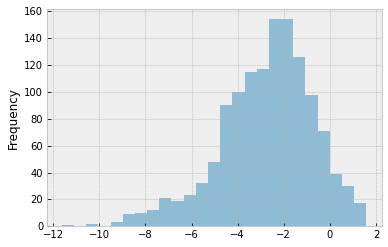

In [9]:
plt.style.use('bmh')
df['Solubility'].plot.hist(alpha=0.5,bins=25)

 This histogram illustrates Solubility distributions.

In [10]:
df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))

I employed RDkit to work with MOL representations. RDkit provides an opportunity to transform SMILES to MOL.

In [11]:
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [12]:
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C', 'O', 'N', 'Cl','PS'], df)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


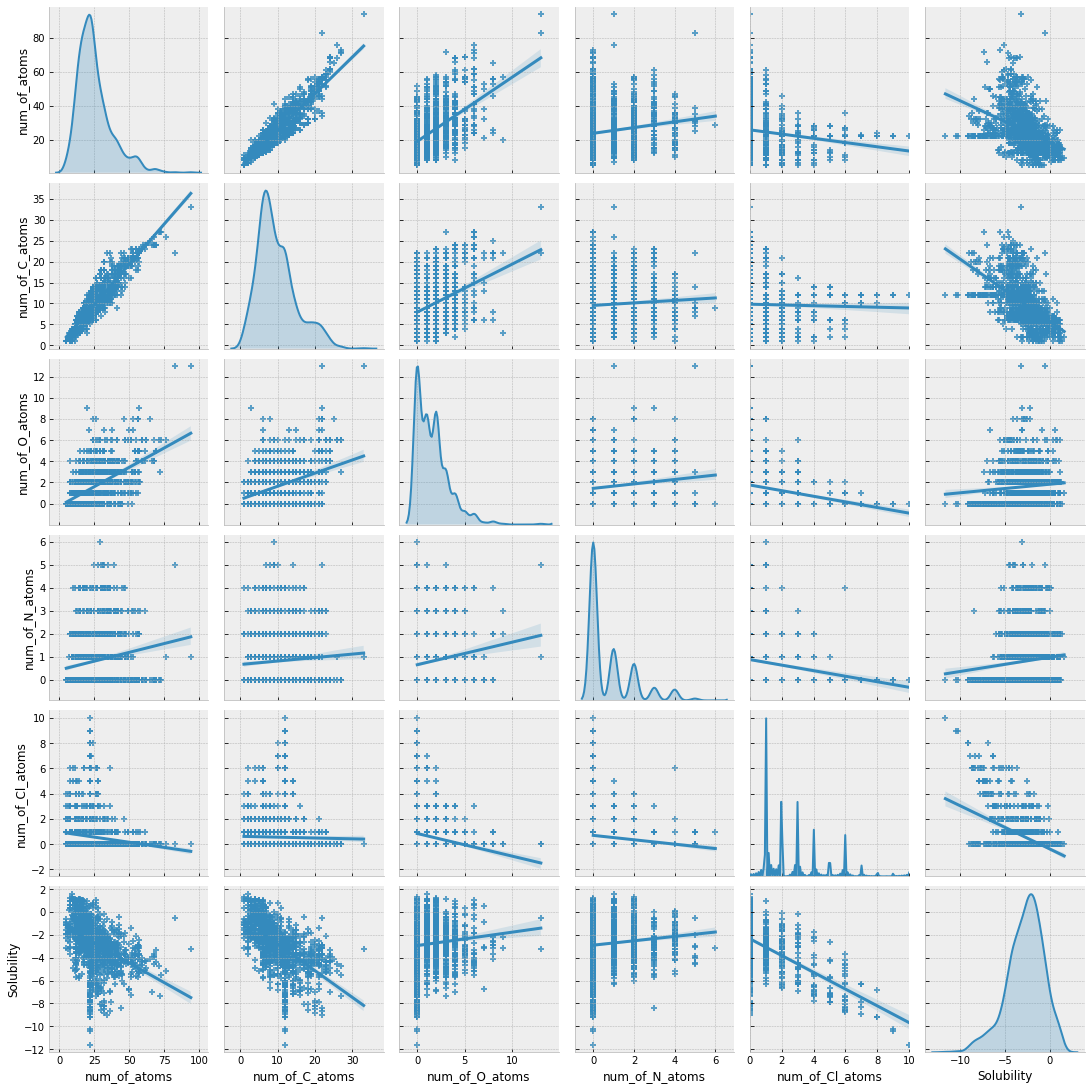

In [13]:
import seaborn as sns
sns.pairplot(df[['num_of_atoms','num_of_C_atoms','num_of_O_atoms', 'num_of_N_atoms','num_of_Cl_atoms', 'Solubility']], diag_kind='kde', kind='reg', markers='+')
plt.show()

In [14]:
from rdkit.Chem import Descriptors
df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x))
df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))


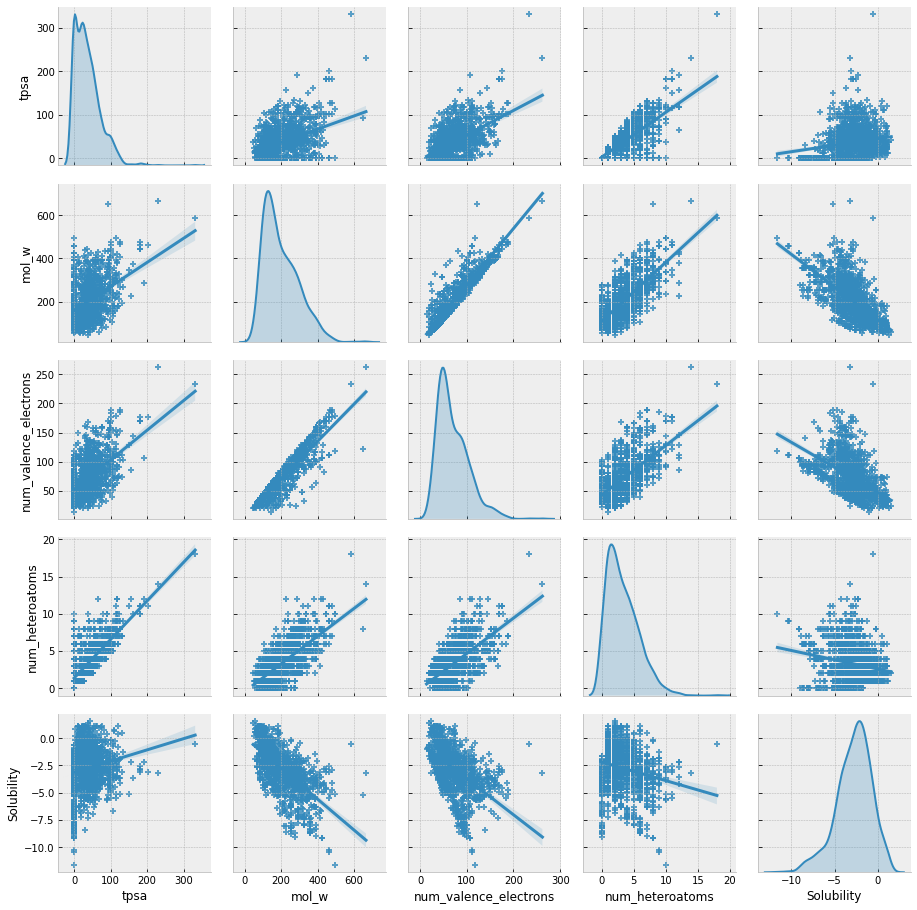

In [15]:
sns.pairplot(df[['tpsa','mol_w','num_valence_electrons', 'num_heteroatoms', 'Solubility']], diag_kind='kde', kind='reg', markers='+')
plt.show()

Lets define feature sets, X = train_df ,
 y = target

In [16]:
train_df = df[['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms', 'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'num_of_PS_atoms','tpsa','mol_w','num_valence_electrons', 'num_heteroatoms']]
target = df['Solubility'].values

# Model Selection

In [17]:
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer,mean_squared_error
from sklearn.feature_selection import mutual_info_regression

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Spliting the data into training and testing sets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_df, target, test_size=0.2, random_state=2)

1- Basic Linear Regression model :
the targets predicted by the linear approximation

Train set R^2:  0.7502501031133573
Train MAE score: 0.7948
Train MSE: 1.0585605288538071
Train RMSE: 1.02886370761817
Test set R^2:  0.6738945640728716
Test MAE score: 0.8754
Test MSE: 1.2549739293588555
Test RMSE: 1.1202561891633787


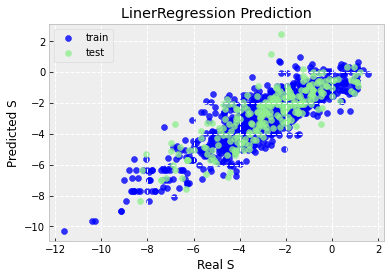

In [20]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))
print('Train MSE:', mean_squared_error(y_train, y_pred_train))
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = model.predict(X_test)
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))
print('Test MSE:', mean_squared_error(y_test, y_pred_test))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))

#plt.xlim((-12,2))
#plt.ylim((-12,2))
plt.title("LinerRegression Prediction")
plt.xlabel("Real S")
plt.ylabel("Predicted S")
plt.grid(color='w', linestyle='--', linewidth=1)
plt.scatter(y_train, model.predict(X_train), 
            color="blue", alpha=0.8, label="train")
plt.scatter(y_test, model.predict(X_test), 
            color="lightgreen", alpha=0.8, label="test")
plt.legend(loc = 'best')
plt.show()

2- Support Vector Machines regression model

Train set R^2:  0.7491082107877223
Train MAE score: 0.7920
Train MSE: 1.0634004193169728
Train RMSE: 1.0312130814322387
Test set R^2:  0.7078168646550094
Test MAE score: 0.8182
Test MSE: 1.1244284119760335
Test RMSE: 1.0603906883672798


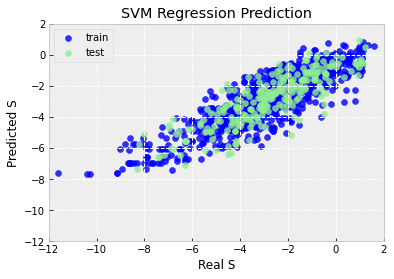

In [22]:
from sklearn.svm import SVR

model = SVR()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))
print('Train MSE:', mean_squared_error(y_train, y_pred_train))
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = model.predict(X_test)
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))
print('Test MSE:', mean_squared_error(y_test, y_pred_test))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))

plt.xlim((-12,2))
plt.ylim((-12,2))
plt.title("SVM Regression Prediction")
plt.xlabel("Real S")
plt.ylabel("Predicted S")
plt.grid(color='w', linestyle='--', linewidth=1)
plt.scatter(y_train, model.predict(X_train), 
            color="blue", alpha=0.8, label="train")
plt.scatter(y_test, model.predict(X_test), 
            color="lightgreen", alpha=0.8, label="test")
plt.legend(loc = 'best')
plt.show()

We use StandardScaler, a rescaling method, to scale features to (-1, 1) range. Data normalization can promote the performance in common machine learning problems. 

Train set R^2:  0.8730790716082126
Train MAE score: 0.5439
Train MSE: 0.5379521143186197
Train RMSE: 0.7334521895247295
Test set R^2:  0.8160467664635587
Test MAE score: 0.6241
Test MSE: 0.7079198531394069
Test RMSE: 0.8413797318330213


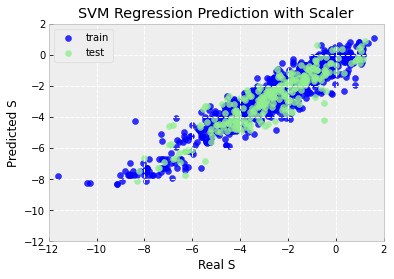

In [23]:
stds = StandardScaler()
stds.fit(X_train)

model = SVR()
model.fit(stds.transform(X_train), y_train)

y_pred_train = model.predict(stds.transform(X_train))
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))
print('Train MSE:', mean_squared_error(y_train, y_pred_train))
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = model.predict(stds.transform(X_test))
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))
print('Test MSE:', mean_squared_error(y_test, y_pred_test))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))

plt.xlim((-12,2))
plt.ylim((-12,2))
plt.title("SVM Regression Prediction with Scaler")
plt.xlabel("Real S")
plt.ylabel("Predicted S")
plt.grid(color='w', linestyle='--', linewidth=1)
plt.scatter(y_train, y_pred_train, 
            color="blue", alpha=0.8, label="train")
plt.scatter(y_test, y_pred_test, 
            color="lightgreen", alpha=0.8, label="test")
plt.legend(loc = 'best')
plt.show()

3- Regression based on k-nearest neighbors

Train set R^2:  0.9509182635046732
Train MAE score: 0.3346
Train MSE: 0.20803207364341084
Train RMSE: 0.4561053317419243
Test set R^2:  0.7970061726054115
Test MAE score: 0.6497
Test MSE: 0.7811950772200773
Test RMSE: 0.8838524069210183


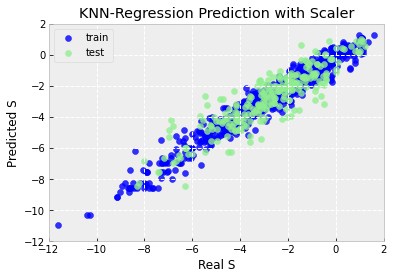

In [24]:
from sklearn.neighbors import KNeighborsRegressor
#from sklearn.neighbors import KNeighborsClassifier
stds = StandardScaler()
stds.fit(X_train)

model = KNeighborsRegressor(n_neighbors=2)
model.fit(stds.transform(X_train), y_train)

y_pred_train = model.predict(stds.transform(X_train))
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))
print('Train MSE:', mean_squared_error(y_train, y_pred_train))
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = model.predict(stds.transform(X_test))
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))
print('Test MSE:', mean_squared_error(y_test, y_pred_test))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))

plt.xlim((-12,2))
plt.ylim((-12,2))
plt.title("KNN-Regression Prediction with Scaler")
plt.xlabel("Real S")
plt.ylabel("Predicted S")
plt.grid(color='w', linestyle='--', linewidth=1)
plt.scatter(y_train, y_pred_train, 
            color="blue", alpha=0.8, label="train")
plt.scatter(y_test, y_pred_test, 
            color="lightgreen", alpha=0.8, label="test")
plt.legend(loc = 'best')
plt.show()

4 -Random Forest Regression

Train set R^2:  0.9768866210293393
Train MAE score: 0.2360
Train MSE: 0.09796564872211401
Train RMSE: 0.3129946464751658
Test set R^2:  0.8551864603623168
Test MAE score: 0.5274
Test MSE: 0.5572958829919005
Test RMSE: 0.7465225267812757


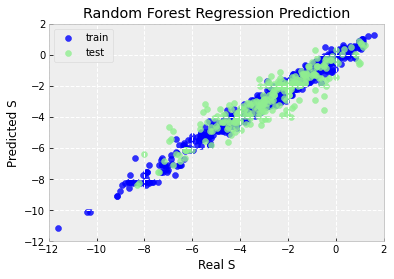

In [25]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_true, y_pred = y_test, model.predict(X_test)

y_pred_train = model.predict(X_train)
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))
print('Train MSE:', mean_squared_error(y_train, y_pred_train))
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = model.predict(X_test)
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))
print('Test MSE:', mean_squared_error(y_test, y_pred_test))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))

plt.xlim((-12,2))
plt.ylim((-12,2))
plt.title("Random Forest Regression Prediction")
plt.xlabel("Real S")
plt.ylabel("Predicted S")
plt.grid(color='w', linestyle='--', linewidth=1)
plt.scatter(y_train, y_pred_train, 
            color="blue", alpha=0.8, label="train")
plt.scatter(y_test, y_pred_test, 
            color="lightgreen", alpha=0.8, label="test")
plt.legend(loc = 'best')
plt.show()

5- Neural Network Perception


Train set R^2:  0.9007229520380567
Train MAE score: 0.4746
Train MSE: 0.42078401514351127
Train RMSE: 0.6486786686361062
Test set R^2:  0.8357190389058429
Test MAE score: 0.5832
Test MSE: 0.6322136970119507
Test RMSE: 0.7951186685092677


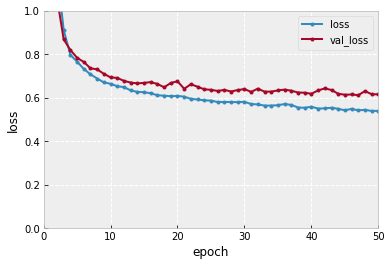

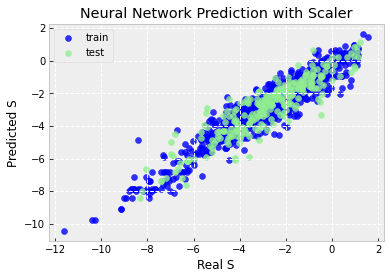

In [26]:
from keras.models import Sequential
from keras.layers import Dense

stds = StandardScaler()
stds.fit(X_train)

model = Sequential()
model.add(Dense(units = 128, input_dim = train_df.shape[1], activation='relu'))
model.add(Dense(units = 1))
 
# model.summary()

model.compile(loss = 'mae',
    optimizer = 'adam',
    metrics=['accuracy'])
history = model.fit(stds.transform(X_train), y_train, epochs = 100, batch_size = 32,
    validation_data = (stds.transform(X_test), y_test), verbose=0)


y_pred_train = model.predict(stds.transform(X_train))
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))
print('Train MSE:', mean_squared_error(y_train, y_pred_train))
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = model.predict(stds.transform(X_test))
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))
print('Test MSE:', mean_squared_error(y_test, y_pred_test))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
plt.xlim((0, 50))
plt.ylim((0, 1))
plt.plot(range(epochs), loss, marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
plt.legend(loc = 'best')
plt.grid(color='w', linestyle='--', linewidth=1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()



#plt.xlim((-12,2))
#plt.ylim((-12,2))
plt.title("Neural Network Prediction with Scaler")
plt.xlabel("Real S")
plt.ylabel("Predicted S")
plt.grid(color='w', linestyle='--', linewidth=1)
plt.scatter(y_train, y_pred_train, 
            color="blue", alpha=0.8, label="train")
plt.scatter(y_test, y_pred_test, 
            color="lightgreen", alpha=0.8, label="test")
plt.legend(loc = 'best')
plt.show()

6-Ridge Regression

Train set R^2:  0.7501543565744351
Train MAE score: 0.7958
Train MSE: 1.0589663488687138
Train RMSE: 1.0290609062969567
Test set R^2:  0.6740604531356604
Test MAE score: 0.8756
Test MSE: 1.2543355270937298
Test RMSE: 1.1199712170827114


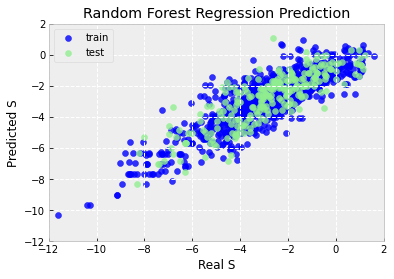

In [27]:
from sklearn.linear_model import RidgeCV

model = RidgeCV(cv=5)
model.fit(X_train, y_train)

y_true, y_pred = y_test, model.predict(X_test)

y_pred_train = model.predict(X_train)
print("Train set R^2: ", r2_score(y_train, y_pred_train))
print("Train MAE score: %.4f" % mean_absolute_error(y_train, y_pred_train))
print('Train MSE:', mean_squared_error(y_train, y_pred_train))
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = model.predict(X_test)
print("Test set R^2: ", r2_score(y_test, y_pred_test))
print("Test MAE score: %.4f" % mean_absolute_error(y_test, y_pred_test))
print('Test MSE:', mean_squared_error(y_test, y_pred_test))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))

plt.xlim((-12,2))
plt.ylim((-12,2))
plt.title("Random Forest Regression Prediction")
plt.xlabel("Real S")
plt.ylabel("Predicted S")
plt.grid(color='w', linestyle='--', linewidth=1)
plt.scatter(y_train, y_pred_train, 
            color="blue", alpha=0.8, label="train")
plt.scatter(y_test, y_pred_test, 
            color="lightgreen", alpha=0.8, label="test")
plt.legend(loc = 'best')
plt.show()